# Transfer Learning - Part 2: Fine Tuning

Feature Extraction vs Fine Tuning
* Feature Extraction has a custom final layer trained on your data. All the underlying layers stay frozen.
* Fine Tuning takes an existing model and unfreezes some of the layers. Fine tuning, usually requires more data than feature extraction.

Things we'll do here:
* Introduce fine tuning learning with tensorflow
* Introduce the keras functional API to build models
* Use a small dataset to experiment faster (10% of training samples)
* Data Augmentation (making your training set more diverse without adding samples)
* Running a series of experiments on our food vision data
* Introduce the ModelCheckpoint callback to save intermediate training results


Other Notes:
* ImageNet has a wide variety of images we can train with
* EfficientNet architecture already works well on computer vision tasks
* We'll tune patterns/weights to our own problem
* Model performs better than from scratch

In [1]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import sys
import os
import pathlib
import random
import urllib.request
import datetime


In [26]:
import helpers.tf_classification_helper_functions as helpers
import imp
imp.reload(helpers)
helpers.show_environment()
helpers.show_gpu_info()

Setting Up Libraries

Python Version: 3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]


Tensorflow Version: 2.4.1


SciKit Learn Versions:

System:
    python: 3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]
executable: C:\Users\timar\AppData\Local\Programs\Python\Python38\python.exe
   machine: Windows-10-10.0.19041-SP0

Python dependencies:
          pip: 21.0.1
   setuptools: 49.2.1
      sklearn: 0.24.1
        numpy: 1.19.5
        scipy: 1.6.2
       Cython: None
       pandas: 1.2.3
   matplotlib: 3.4.1
       joblib: 1.0.1
threadpoolctl: 2.1.0

Built with OpenMP: True


GPU Device Name: /device:GPU:0, Physical GPU Device List: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device:/device:GPU:0


# Downloading the Data

Get 10% of 10 food classes from food 101

* The zip file we use in this notebook [is here](https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip).


In [3]:
#Setup variables for our data
if os.name == "nt":
    zip_download_file = "c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent.zip"
    zip_extract_location = "c:/temp/data/10_food_classes_10_percent/"
    data_dir = "c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent"
else:
    zip_download_file = "/home/pi/Dev/data/10_food_classes_10_percent/10_food_classes_10_percent.zip"
    zip_extract_location = "/home/pi/Dev/data/10_food_classes_10_percent/"
    data_dir = "/home/pi/Dev/data/10_food_classes_10_percent/10_food_classes_10_percent"

train_data_dir = data_dir + "/train"
test_data_dir = data_dir + "/test"

In [4]:
# Get the data set
# TODO: UNCOMMENT ME if you havent downloaded it yet
#if not os.path.isfile(zip_download_file):
#    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip -O $zip_download_file

In [5]:
# Unzip the data
# Get the data set
# TODO: UNCOMMENT ME if you havent downloaded and unzipped it yet
if not os.path.exists(data_dir):
    zip_ref = zipfile.ZipFile(zip_download_file)
    zip_ref.extractall(path=zip_extract_location)
    zip_ref.close()

In [6]:
# Walk through the data directory and list number of files
helpers.walk_directory(data_dir)


There are 2 directories and 0 files in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent
There are 10 directories and 0 files in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test
There are 0 directories and 250 files in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\chicken_curry
There are 0 directories and 250 files in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\chicken_wings
There are 0 directories and 250 files in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\fried_rice
There are 0 directories and 250 files in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\grilled_salmon
There are 0 directories and 250 files in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\hamburger
There are 0 directories and 250 files in c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent\test\ice_cream
There are 0 directories and 25

# 1. Visualize our Images

In [7]:
class_names = helpers.get_class_names_from_directory(data_dir+"/train/")
print(class_names), len(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


(None, 10)

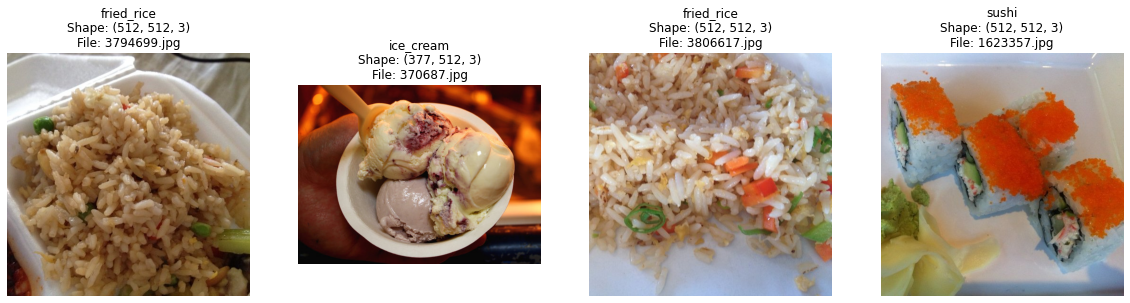

In [8]:
# View a random image from the training data set
helpers.view_random_images_from_directory (
    directory = train_data_dir, 
    class_names = class_names,
    #Optionally pass in a specific class to show only images from that class
    #class_to_show = random.choice(class_names),
    num_images=4,
    figsize=(20,20)
)

# 2. Preprocess our Images

Our next step is to turn our data into batches and load our training and test sets.

A batch is a small subset of data. Rather than look at all ~10k images, a model might only look at 32 at a time. 

It does this for a couple of reasons:
* 10k images might not fit into the memory of the procesor
* Trying to learn the patterns in 10k images in one hit could result in the model not being able to learn very well.

Why 32?

Because 32 is good for your health per Yann Lecun. (google yann lecun batchsize, see his twitter post). Yann Lecun is a professor at NYU

In [9]:
#Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

# Set the seed for reproducibility
tf.random.set_seed(42)

def normalize_image(image,label):
    image = tf.cast(image/255., tf.float32)
    return image,label

# image_dataset_from_directory creates a tf.data.DataSet return type and is faster
# than using ImageDataGenerator.flow_from_directory
train_data = tf.keras.preprocessing.image_dataset_from_directory (
    directory=train_data_dir,
    # Reshape all the images to be the same size. 
    image_size=IMAGE_SIZE,
    label_mode = "categorical", # categorical (2d one hot encoded labels) or binary
    batch_size = BATCH_SIZE,
    seed = 42
)
train_data = train_data.map(normalize_image)

test_data = tf.keras.preprocessing.image_dataset_from_directory (
    directory=test_data_dir,
    # Reshape all the images to be the same size. 
    image_size=IMAGE_SIZE,
    label_mode = "categorical", # categorical (2d one hot encoded labels) or binary
    batch_size = BATCH_SIZE,
    seed = 42
)
test_data = test_data.map(normalize_image)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
#Shape is 224x224 image with 3 color channels, and then a 1 hot encoded label
train_data

<MapDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [11]:
# This doesnt work yet because when we normalize above we get a MapDataSet instead of a BatchDataset
#train_data.class_names

In [12]:
train_data.take(1)

<TakeDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [13]:
# Get a sample of train data batch
# image_dataset_from_directory returns a BatchDataset. We have to call take in a for loop with the
# number of batches to take
for images, labels in train_data.take(1):
    #len(images), len(labels)
    #print("Took dataset")
    None # No-op

len(images), len(labels)

(32, 32)

In [14]:
# How many batches are there
len(train_data) # This equals 1500 images divided by batch size of 32, rounded up

24

In [15]:
# Show a random image and its label from our Image Generator/Loader
import random
def view_random_image_from_data_generator_iterator(images, labels):
    # Return a number between 0 and the length of our images array (both included)
    random_number = random.randint(0, len(images)-1)
    label_index = np.argmax(labels[random_number])
    print(f"Showing image number {random_number}")
    image_shape = images[random_number].shape
    plt.imshow(images[random_number])
    plt.title(f"{class_names[label_index]}\nShape: {image_shape}")
    plt.axis(False)

Showing image number 27


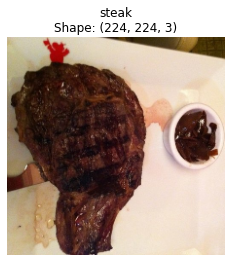

In [16]:
view_random_image_from_data_generator_iterator(images, labels)

# Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight forward, it runs our layers in sequential order.
But the funtional API gives us more flexibility with our models.


In [17]:
# 1. Create a base model with tf.keras.applications
# The top layer has 1000 output neurons for the model trained on ImageNet. We want to
# be able to specify that our model has a different number of outputs
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3),  name="input_layer")

# 4. If using a model like Resnet50V2 you will need to normalize inputs (you dont have to for efficient nets)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the Model
model_0.compile (
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Create a tensorboard callback
tensorboard_callback = helpers.create_tensorboard_callback("c:/temp/data/05_tensorboard", "model_0")

#10. Fit the model and save its history
history_0 = model_0.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[tensorboard_callback]
)


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: c:/temp/data/05_tensorboard/model_0/20210417-142148
Epoch 1/5
24/24 [==============================] - 20s 549ms/step - loss: 2.3194 - accuracy: 0.1073 - val_loss: 2.3047 - val_accuracy: 0.1000
Epoch 2/5
24/24 [==============================] - 9s 360ms/step - loss: 2.3175 - accuracy: 0.0563 - val_loss: 2.3037 - val_accuracy: 0.0996
Epoch 3/5
24/24 [==============================] - 9s 361ms/step - loss: 2.3089 - accuracy: 0.1063 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 4/5
24/24 [==============================] - 9s 363ms/step - loss: 2.3077 - accuracy: 0.0983 - val_loss: 2.3041 - val_accuracy: 0.1000
Epoch 5/5
24/24 [==============================] - 9s 365ms/step - loss: 2.3112 - accuracy: 0.0984 - val_loss: 2.3030 - val_accuracy: 0.1000


In [18]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [19]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 2.3030 - accuracy: 0.1000


[2.3030292987823486, 0.10000000149011612]

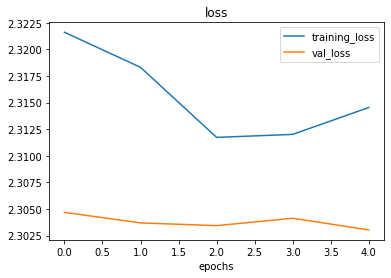

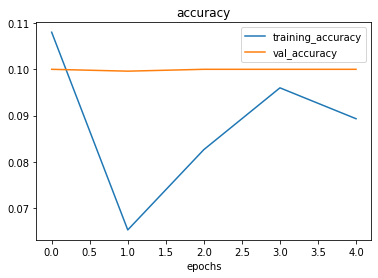

In [20]:
# Checkout the loss and accuracy of the model
# If training loss is decreasing, but validation loss is increasing, then it shows our model is overfitting.
# If the model is overfitting (learning the training data too well) it will get great results on the 
# training data, but it is failing to generalize well to unseen data and it performs poorly on the test data.
helpers.plot_loss_curves(history_0)


[[0.09841672 0.09837433 0.09545168 0.1024425  0.0967469  0.10132004
  0.10092609 0.09894882 0.10694753 0.10042538]]


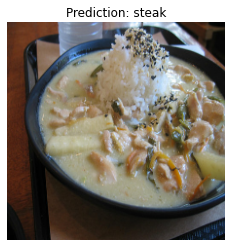

In [32]:
#Steak
#helpers.predict_and_plot(model_0, "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg", class_names = class_names)

helpers.predict_and_plot(model_0, "file:///c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent/test/chicken_curry/838.jpg", class_names = class_names)

#helpers.predict_and_plot(resnet_model, "https://hips.hearstapps.com/del.h-cdn.co/assets/18/08/1519155106-flank-steak-horizontal.jpg")

#Pizza
#helpers.predict_and_plot(resnet_model, "https://upload.wikimedia.org/wikipedia/commons/1/10/Pepperoni_pizza.jpeg")

#Curry
#helpers.predict_and_plot(resnet_model, "https://images.squarespace-cdn.com/content/v1/57bb2e8cb3db2b9076db6369/1529609506001-AI7Y83VYPGIFN3SVU7AB/ke17ZwdGBToddI8pDm48kLkXF2pIyv_F2eUT9F60jBl7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z4YTzHvnKhyp6Da-NYroOW3ZGjoBKy3azqku80C789l0iyqMbMesKd95J-X4EagrgU9L3Sa3U8cogeb0tjXbfawd0urKshkc5MgdBeJmALQKw/AdobeStock_142271660.jpeg")